# Processing Milwaukee Label (~3K labels) 

Building on `2020-03-24-EDA-Size.ipynb`

Goal is to prep a standard CSV that we can update and populate

In [100]:
import pandas as pd
import numpy as np
import os
import s3fs # for reading from S3FileSystem
import json # for working with JSON files 

import matplotlib.pyplot as plt


pd.set_option('max_colwidth', -1)

In [7]:
# Import custom modules
import sys
SWKE_PATH = r'/home/ec2-user/SageMaker/classify-streetview/swke'
sys.path.append(SWKE_PATH)

import labelcrops


In [8]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'
SPLIT_PATH = os.path.join(SAGEMAKER_PATH, 'classify-streetview', 'split-train-test')

# Alternative Template - row for ~3K labels x # crops appeared in

* img_id
* heading
* crop_id
* label
* dist_x_left
* dist_x_right
* dist_y_top
* dist_y_bottom

In [9]:
df_labels = pd.read_csv(os.path.join(SPLIT_PATH, 'restructure_single_labels.csv'))
print(df_labels.shape)
df_labels.head()

(2851, 18)


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null,sv_image_x,sv_image_y,sv_image_y_bottom_origin,label_name
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False,108,389,251,Present Curb Ramp
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,160,389,251,Present Curb Ramp
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,607,453,187,Present Curb Ramp
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,18,475,165,Present Curb Ramp
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,245,413,227,Present Curb Ramp


In [10]:
df_coor = pd.read_csv('crop_coor.csv')
df_coor

,crop_number,corner_x,corner_y,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom
0,1,0,200,220,0,220,200,420
1,2,140,200,220,140,360,200,420
2,3,280,200,220,280,500,200,420
3,4,420,200,220,420,640,200,420
4,5,0,340,300,0,300,340,640
5,6,170,340,300,170,470,340,640
6,7,340,340,300,340,640,340,640


In [11]:
df_outer = pd.merge(left=df_labels, right=df_coor, how='outer')
df_outer.shape

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [13]:
df_outer = pd.concat([df_labels, df_coor],  axis = 1)

In [15]:
df_outer.head(10)

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,sv_image_y_bottom_origin,label_name,crop_number,corner_x,corner_y,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,251,Present Curb Ramp,1.0,0.0,200.0,220.0,0.0,220.0,200.0,420.0
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,251,Present Curb Ramp,2.0,140.0,200.0,220.0,140.0,360.0,200.0,420.0
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,...,187,Present Curb Ramp,3.0,280.0,200.0,220.0,280.0,500.0,200.0,420.0
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,...,165,Present Curb Ramp,4.0,420.0,200.0,220.0,420.0,640.0,200.0,420.0
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,...,227,Present Curb Ramp,5.0,0.0,340.0,300.0,0.0,300.0,340.0,640.0
5,680_135.jpg,51194,{},6,2,"{""name"":""point"",""cx"":266,""cy"":392}","{""Obstacle"":""5""}",680,False,False,...,248,Obstacle,6.0,170.0,340.0,300.0,170.0,470.0,340.0,640.0
6,680_135.jpg,51194,{},6,3,"{""name"":""point"",""cx"":545,""cy"":373}","{""Obstacle"":""5""}",680,False,False,...,267,Obstacle,7.0,340.0,340.0,300.0,340.0,640.0,340.0,640.0
7,680_135.jpg,51194,{},6,4,"{""name"":""point"",""cx"":560,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,251,Present Curb Ramp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,680_135.jpg,51194,{},6,5,"{""name"":""point"",""cx"":591,""cy"":374}","{""Obstacle"":""1\n""}",680,False,False,...,266,Obstacle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,680_225.jpg,47450,{},4,0,"{""name"":""point"",""cx"":179,""cy"":411}","{""Surface Problem"":""1""}",680,False,False,...,229,Surface Problem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Let's just use a for loop and join back together
list_dfs = []
coor_cols = list(df_coor.columns)
for index, row in df_coor.iterrows():
    df_temp_labels = df_labels
    for col in coor_cols:
        df_temp_labels[col] = row[col]
    list_dfs.append(df_temp_labels)
    print(df_temp_labels.shape)

(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)


In [44]:
# Let's just use a for loop and join back together
list_dfs = []
coor_cols = list(df_coor.columns)
for index, row in df_coor.iterrows():
    df_temp_labels = df_labels.copy()
    for col in coor_cols:
        df_temp_labels[col] = row[col]
    list_dfs.append(df_temp_labels)
    print(df_temp_labels.shape)

(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)
(2851, 26)


In [45]:
df_concat = pd.concat(list_dfs)
df_concat.shape

(19957, 26)

In [46]:
df_concat['corner_x'].value_counts()

0      5702
140    2851
170    2851
280    2851
420    2851
340    2851
Name: corner_x, dtype: int64

In [47]:
df_concat.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,sv_image_y_bottom_origin,label_name,crop_number,corner_x,corner_y,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,251,Present Curb Ramp,1,0,200,220,0,220,200,420
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,251,Present Curb Ramp,1,0,200,220,0,220,200,420
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,...,187,Present Curb Ramp,1,0,200,220,0,220,200,420
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,...,165,Present Curb Ramp,1,0,200,220,0,220,200,420
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,...,227,Present Curb Ramp,1,0,200,220,0,220,200,420


In [48]:
df_concat.to_csv('merged_crops_template.csv', index = False)

In [49]:
df_concat.columns

Index(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes', 'img_id',
       'present_ramp', 'missing_ramp', 'obstacle', 'surface_prob',
       'no_sidewalk', 'null', 'sv_image_x', 'sv_image_y',
       'sv_image_y_bottom_origin', 'label_name', 'crop_number', 'corner_x',
       'corner_y', 'size', 'x_crop_left', 'x_crop_right', 'y_crop_top',
       'y_crop_bottom'],
      dtype='object')

## Take the differences 

In [50]:
df_concat['xpt_minus_xleft'] = df_concat['sv_image_x'] - df_concat['x_crop_left']
df_concat['xright_minus_xpt'] = df_concat['x_crop_right'] - df_concat['sv_image_x']
df_concat['ypt_minus_ytop'] = df_concat['sv_image_y'] - df_concat['y_crop_top']
df_concat['ybottom_minus_ypt'] = df_concat['y_crop_bottom'] - df_concat['sv_image_y']

In [51]:
positive_mask = (df_concat['xpt_minus_xleft'] > 0) & (df_concat['xright_minus_xpt'] > 0) & (df_concat['ypt_minus_ytop'] > 0) & (df_concat['ybottom_minus_ypt'] > 0)
df_concat['label_in_crop'] = positive_mask
df_concat['label_in_crop'].value_counts()

False    12919
True     7038 
Name: label_in_crop, dtype: int64

In [52]:
df_incrop = df_concat.loc[df_concat['label_in_crop']]
df_incrop.shape

(7038, 31)

In [53]:
df_incrop['crop_number'].value_counts()

6    1802
5    1294
7    1243
3    894 
2    877 
1    481 
4    447 
Name: crop_number, dtype: int64

In [54]:
df_incrop.to_csv('Crops_with_Labels.csv', index = False)

In [55]:
7038 / 2851

2.468607506138197

## Observations
* We have 12919 Null Crops
* We have 7038 Crops with a feature in them
* Three bottom crops (5, 6, 7) have the most points (these are the biggest)
* The 3 middle crops have the most for their row (2, 3, 6)
* Labels appear in an average of 2.47 image crops

# Visualize Label Locations

* xpt_minus_xleft - x location in the crop relative to bottom left (0, 0)
* ybottom_minus_ypt - y location in the crop relative to bottom left (0, 0)

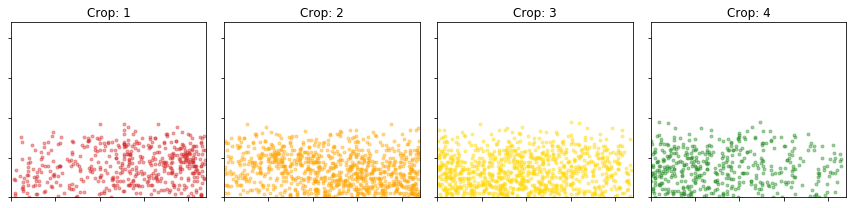

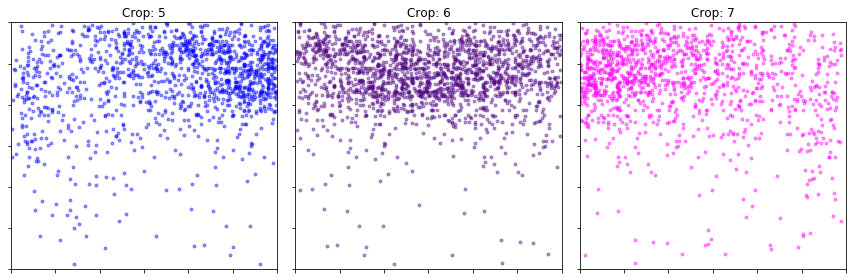

In [74]:
fig = plt.figure(figsize = (12, 3))

colors_list = ['tab:red', 'orange', 'gold', 'forestgreen']

for crop_id in range(1, 5):
    ax = fig.add_subplot(1, 4, crop_id)
    x = df_incrop['xpt_minus_xleft'].loc[df_incrop['crop_number'] == crop_id]
    y = df_incrop['ybottom_minus_ypt'].loc[df_incrop['crop_number'] == crop_id]
    ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[int(crop_id -1)])
    #ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
    plt.ylim(0, 220)
    plt.xlim(0, 220)
    plt.title(f'Crop: {crop_id}')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tight_layout()

fig2 = plt.figure(figsize = (12, 4))

# colors_list = ['forestgreen', 'indigo', 'mediumblue', 'gold', 'tab:red']
colors_list = ['blue', 'indigo', 'fuchsia']

for crop_id in range(5, 8):
    plot_num = crop_id - 4
    ax2 = fig2.add_subplot(1, 3, plot_num)
    x = df_incrop['xpt_minus_xleft'].loc[df_incrop['crop_number'] == crop_id]
    y = df_incrop['ybottom_minus_ypt'].loc[df_incrop['crop_number'] == crop_id]
    ax2.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[int(plot_num - 1)])
    #ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
    plt.ylim(0, 300)
    plt.xlim(0, 300)
    plt.title(f'Crop: {crop_id}')
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    plt.tight_layout()

# Deep Dive into df_incrop

In [75]:
df_incrop.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom,xpt_minus_xleft,xright_minus_xpt,ypt_minus_ytop,ybottom_minus_ypt,label_in_crop
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,220,0,220,200,420,108,112,189,31,True
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,220,0,220,200,420,160,60,189,31,True
9,680_225.jpg,47450,{},4,0,"{""name"":""point"",""cx"":179,""cy"":411}","{""Surface Problem"":""1""}",680,False,False,...,220,0,220,200,420,179,41,211,9,True
17,1042_45.jpg,45436,{},3,1,"{""name"":""point"",""cx"":90,""cy"":380}","{""Obstacle"":""1""}",1042,False,False,...,220,0,220,200,420,90,130,180,40,True
18,1042_45.jpg,45436,{},3,2,"{""name"":""point"",""cx"":69,""cy"":363}","{""Obstacle"":""2""}",1042,False,False,...,220,0,220,200,420,69,151,163,57,True


In [76]:
df_incrop.columns

Index(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes', 'img_id',
       'present_ramp', 'missing_ramp', 'obstacle', 'surface_prob',
       'no_sidewalk', 'null', 'sv_image_x', 'sv_image_y',
       'sv_image_y_bottom_origin', 'label_name', 'crop_number', 'corner_x',
       'corner_y', 'size', 'x_crop_left', 'x_crop_right', 'y_crop_top',
       'y_crop_bottom', 'xpt_minus_xleft', 'xright_minus_xpt',
       'ypt_minus_ytop', 'ybottom_minus_ypt', 'label_in_crop'],
      dtype='object')

In [77]:
incrop_keep_cols = ['filename', 'crop_number', 'region_id', 'label_name', 'region_count', 'img_id',
       'sv_image_x', 'sv_image_y','sv_image_y_bottom_origin', 'xpt_minus_xleft', 'xright_minus_xpt',
       'ypt_minus_ytop', 'ybottom_minus_ypt']
df_incrop_short = df_incrop[incrop_keep_cols].copy()
df_incrop_short.head()

,filename,crop_number,region_id,label_name,region_count,img_id,sv_image_x,sv_image_y,sv_image_y_bottom_origin,xpt_minus_xleft,xright_minus_xpt,ypt_minus_ytop,ybottom_minus_ypt
0,680_45.jpg,1,0,Present Curb Ramp,3,680,108,389,251,108,112,189,31
1,680_45.jpg,1,1,Present Curb Ramp,3,680,160,389,251,160,60,189,31
9,680_225.jpg,1,0,Surface Problem,4,680,179,411,229,179,41,211,9
17,1042_45.jpg,1,1,Obstacle,3,1042,90,380,260,90,130,180,40
18,1042_45.jpg,1,2,Obstacle,3,1042,69,363,277,69,151,163,57


In [80]:
# Make some new ids
df_incrop_short['heading'] = df_incrop_short['filename'].str.extract('(.*)_(.*).jpg', expand = True)[1]
df_incrop_short.dtypes

filename                    object
crop_number                 int64 
region_id                   int64 
label_name                  object
region_count                int64 
img_id                      int64 
sv_image_x                  int64 
sv_image_y                  int64 
sv_image_y_bottom_origin    int64 
xpt_minus_xleft             int64 
xright_minus_xpt            int64 
ypt_minus_ytop              int64 
ybottom_minus_ypt           int64 
heading                     object
crop_name_id                object
label_id                    object
dtype: object

In [81]:
#df_incrop_short['crop_name_id'] = df_incrop_short[['img_id', 'heading', 'crop_number']].apply(lambda x: '_'.join(str(x)), axis=1)
#df_incrop_short['label_id'] = df_incrop_short[['img_id', 'heading', 'region_id']].apply(lambda x: '_'.join(str(x)), axis=1)

df_incrop_short['crop_name_id'] = df_incrop_short['img_id'].astype(str) + '_' + df_incrop_short['heading'] + '_' + df_incrop_short['crop_number'].astype(str)
df_incrop_short['label_id'] = df_incrop_short['img_id'].astype(str) + '_' + df_incrop_short['heading'] + '_' + df_incrop_short['region_id'].astype(str)

df_incrop_short.head()

,filename,crop_number,region_id,label_name,region_count,img_id,sv_image_x,sv_image_y,sv_image_y_bottom_origin,xpt_minus_xleft,xright_minus_xpt,ypt_minus_ytop,ybottom_minus_ypt,heading,crop_name_id,label_id
0,680_45.jpg,1,0,Present Curb Ramp,3,680,108,389,251,108,112,189,31,45,680_45_1,680_45_0
1,680_45.jpg,1,1,Present Curb Ramp,3,680,160,389,251,160,60,189,31,45,680_45_1,680_45_1
9,680_225.jpg,1,0,Surface Problem,4,680,179,411,229,179,41,211,9,225,680_225_1,680_225_0
17,1042_45.jpg,1,1,Obstacle,3,1042,90,380,260,90,130,180,40,45,1042_45_1,1042_45_1
18,1042_45.jpg,1,2,Obstacle,3,1042,69,363,277,69,151,163,57,45,1042_45_1,1042_45_2


In [82]:
df_incrop_short['crop_name_id'].value_counts()

4726_315_6     7
4726_135_7     7
12367_315_6    6
4684_135_7     6
4550_45_6      6
8829_135_5     6
12367_315_2    6
8945_135_7     5
17973_225_5    5
8829_135_1     5
17973_225_6    5
5362_135_6     5
4726_315_3     5
4726_315_2     5
2792_135_3     5
7389_135_6     5
4550_315_6     5
9023_225_7     5
2792_135_7     5
17385_225_6    5
3577_225_6     5
13806_45_6     4
12277_45_6     4
8715_225_7     4
18242_315_5    4
7691_315_6     4
4726_225_4     4
7481_135_6     4
18920_45_2     4
18514_45_6     4
              ..
7837_45_7      1
1926_45_6      1
6653_315_7     1
14540_225_5    1
2555_45_3      1
14188_135_3    1
7837_315_5     1
7362_135_7     1
19034_135_6    1
18272_225_1    1
16614_225_5    1
17408_315_3    1
8780_135_7     1
1297_315_3     1
17252_315_6    1
8558_135_6     1
7481_315_3     1
8861_315_5     1
17062_225_3    1
7481_225_5     1
18399_225_1    1
7362_315_6     1
17179_135_3    1
4016_45_6      1
14391_315_6    1
7552_45_2      1
4845_315_6     1
19102_135_6   

In [85]:
crop_label_counts = df_incrop_short['crop_name_id'].value_counts()
crop_label_counts.value_counts()

1    3868
2    1088
3    228 
4    49  
5    14  
6    5   
7    2   
Name: crop_name_id, dtype: int64

In [86]:
label_id_counts = df_incrop_short['label_id'].value_counts()
label_id_counts.value_counts()

2    934
3    833
1    555
4    529
Name: label_id, dtype: int64

In [87]:
label_id_counts.head(20)

17180_45_1     4
15245_135_0    4
18145_225_0    4
4093_135_0     4
4768_315_0     4
8945_45_4      4
14455_225_4    4
18432_135_0    4
3905_225_0     4
10702_45_0     4
10782_315_1    4
10782_315_0    4
12367_225_2    4
2678_45_0      4
7552_315_3     4
4945_45_2      4
6852_225_1     4
10702_315_1    4
17047_135_0    4
16376_135_0    4
Name: label_id, dtype: int64

In [83]:
506 * 7 * 4

14168

In [84]:
14168 - 5254

8914

In [88]:
df_incrop_short.to_csv('incrop_labels.csv', index = False)

# Desired End Template CSV for 506 x 7 x 4 image crops

* img_id
* heading
* crop_id
* combined_id
* primary_label - based on a hierarchy of importance
* 0_missing_count
* 1_null_count
* 2_obstacle_count
* 3_present_count
* 4_surface_prob_count
* 5_nosidewalk_count

In [97]:
unique_labels_list = list(df_incrop_short['label_name'].unique())

In [98]:
folders_list = ['3_present', '4_surface_prob', '2_obstacle', '0_missing', '6_occlusion', '5_nosidewalk']

In [101]:
for label, folder in zip(unique_labels_list, folders_list):
    label_mask = (df_incrop_short['label_name'].str.contains(label))
    df_incrop_short[folder] = np.where(label_mask, 1, 0)

df_incrop_short.head()

,filename,crop_number,region_id,label_name,region_count,img_id,sv_image_x,sv_image_y,sv_image_y_bottom_origin,xpt_minus_xleft,...,ybottom_minus_ypt,heading,crop_name_id,label_id,3_present,4_surface_prob,2_obstacle,0_missing,6_occlusion,5_nosidewalk
0,680_45.jpg,1,0,Present Curb Ramp,3,680,108,389,251,108,...,31,45,680_45_1,680_45_0,1,0,0,0,0,0
1,680_45.jpg,1,1,Present Curb Ramp,3,680,160,389,251,160,...,31,45,680_45_1,680_45_1,1,0,0,0,0,0
9,680_225.jpg,1,0,Surface Problem,4,680,179,411,229,179,...,9,225,680_225_1,680_225_0,0,1,0,0,0,0
17,1042_45.jpg,1,1,Obstacle,3,1042,90,380,260,90,...,40,45,1042_45_1,1042_45_1,0,0,1,0,0,0
18,1042_45.jpg,1,2,Obstacle,3,1042,69,363,277,69,...,57,45,1042_45_1,1042_45_2,0,0,1,0,0,0


In [102]:
df_group = df_incrop_short.groupby(['img_id', 'heading', 'crop_number'])[folders_list].sum()
df_group.head()

3_present  4_surface_prob  2_obstacle  0_missing  \
img_id heading crop_number                                                     
141    135     2            0          1               0           0           
               3            1          1               0           0           
               5            0          1               0           0           
               6            1          1               0           0           
               7            1          0               0           0           

                            6_occlusion  5_nosidewalk  
img_id heading crop_number                             
141    135     2            0            0             
               3            0            0             
               5            0            0             
               6            0            0             
               7            0            0

In [106]:
df_group['count_all'] = df_group[folders_list].values.sum(axis = 1)
df_group.head()

3_present  4_surface_prob  2_obstacle  0_missing  \
img_id heading crop_number                                                     
141    135     2            0          1               0           0           
               3            1          1               0           0           
               5            0          1               0           0           
               6            1          1               0           0           
               7            1          0               0           0           

                            6_occlusion  5_nosidewalk  count_all  
img_id heading crop_number                                        
141    135     2            0            0             1          
               3            0            0             2          
               5            0            0             1          
               6            0            0             2          
               7            0            0             1

In [107]:
df_group.shape

(5254, 7)

In [108]:
df_group = df_group.reset_index()
df_group.head()

,img_id,heading,crop_number,3_present,4_surface_prob,2_obstacle,0_missing,6_occlusion,5_nosidewalk,count_all
0,141,135,2,0,1,0,0,0,0,1
1,141,135,3,1,1,0,0,0,0,2
2,141,135,5,0,1,0,0,0,0,1
3,141,135,6,1,1,0,0,0,0,2
4,141,135,7,1,0,0,0,0,0,1


In [109]:
df_group.to_csv('img_heading_crop_labelcounts.csv', index = False)

In [113]:
df_group[folders_list].sum()

3_present         4273
4_surface_prob    1068
2_obstacle        402 
0_missing         268 
6_occlusion       72  
5_nosidewalk      955 
dtype: int64

In [114]:
(df_group[folders_list] > 0).sum()

3_present         3850
4_surface_prob    754 
2_obstacle        326 
0_missing         254 
6_occlusion       72  
5_nosidewalk      620 
dtype: int64

In [ ]:
df_group[folders_list].sum()

# Next Phase

* Grab a couple thousand null crops
* Find out which ones are null by creating a img_id x heading x all crop_numbers list and then doing a join with df_group
* Then fill in the NAs with 0s and add a new column that if count_all == 0, then 1_null = 1
* Then merge with the test/train names by img_id
* Then move those crops into the test folder